# Setup

conda create -n tfpy37 python==3.7<br>
conda activate tfpy37<br>
conda install tensorflow<br>
conda install pandas nltk scikit-learn<br>
python -m nltk download all<br>
conda install -c conda-forge wordcloud<br>
conda install -c anaconda gensim<br>
conda install -c conda-forge pyldavis<br>

## Loading Dataset

In [1]:
import pandas as pd
df = pd.read_csv('kaggle_fake_news.csv',encoding = 'latin-1')

Dropping records with labels not described by author.

In [2]:
df = df[~df['Label'].isin(['full-flop','half-flip','no-flip'])]
df.shape

(9855, 6)

## Data Cleaning

Data Cleaning Steps for Neural Network:

- Replacing Latin character '\xa0' (hard space) using regex with single space
- Removing single apostrophe
- Adding spaces around full stops to improve tokenization
- removing remaining latin characters
- lowering text
- removing punctuation
- tokenizing words

Q: Why have we not removed stop words? <br>
A: In our model we have an LSTM layer that processes sequence of words to extract features. Stop words add further information to this sequence that needs to be retained.

In [3]:
import re
import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

In [4]:
def preprocess(text):
    text = re.sub(r'\xa0',' ',text)
    text = re.sub(r"'",'',text)
    text = re.sub("([a-zA-Z])\\.",r'\1 . ',text)
    text = re.sub(r'[^\x00-\x7F]','', text)
    text = text.lower()
    text = "".join([char for char in text if char not in string.punctuation])
    words = word_tokenize(text)

    return ' '.join(word_tokenize(text))

In [5]:
%%time
# Creating new columns for cleaned text
df['cleanText'] = df['News_Headline'].apply(preprocess)

Wall time: 2.58 s


Data Cleaning Steps for exploration:

- Replacing Latin character '\xa0' (hard space) using regex with single space
- Removing single apostrophe
- Adding spaces around full stops to improve tokenization
- removing remaining latin characters
- lowering text
- removing stop words
- removing punctuation
- tokenizing words

for exploratory analysis we require only relevent words to prevent clutter in the visualizations

In [6]:
other_words = ['say','says']
stop_words = set(stopwords.words('english')+other_words)

def preprocess_v2(text):
    text = re.sub(r'\xa0',' ',text)
    text = re.sub(r"'",'',text)
    text = re.sub("([a-zA-Z])\\.",r'\1 . ',text)
    text = re.sub(r'[^\x00-\x7F]','', text)
    text = text.lower() 
    text = "".join([char for char in text if char not in string.punctuation])
    words = word_tokenize(text)
    
    filtered_words = ' '.join([word for word in words if word not in stop_words])
    return filtered_words
    return ' '.join(word_tokenize(text))

In [7]:
df['very_clean_text'] = df['News_Headline'].apply(preprocess_v2)

## Exploratory Analysis<br> This section can be skipped, go directly to data preparation.


Using Latent Dircholet Algorithm to understand significance of words and how they categorize information to form topics

In [32]:
import warnings
warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [33]:
from gensim import corpora
import gensim
import pickle
import os
import pyLDAvis
import pyLDAvis.gensim_models

In [10]:
docs = df.very_clean_text.apply(lambda x:x.split(' ')).values
dictionary = corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(d) for d in docs]

In [11]:
NUM_TOPICS = 4
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
# ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.007*"percent" + 0.006*"new" + 0.004*"time" + 0.004*"walker"')
(1, '0.012*"people" + 0.010*"health" + 0.008*"care" + 0.008*"tax"')
(2, '0.018*"president" + 0.014*"trump" + 0.014*"obama" + 0.011*"said"')
(3, '0.024*"percent" + 0.014*"years" + 0.012*"states" + 0.010*"year"')


In [12]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('../results/ldavis_prepared_'+str(NUM_TOPICS))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '../results/ldavis_prepared_'+ str(NUM_TOPICS) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.014943 -0.107297       1        1  30.801977
2     -0.193836 -0.083062       2        1  27.389839
3      0.222808 -0.023010       3        1  23.837531
0     -0.043916  0.213369       4        1  17.970653, topic_info=           Term        Freq       Total Category  logprob  loglift
100   president  532.000000  532.000000  Default  30.0000  30.0000
1165    percent  839.000000  839.000000  Default  29.0000  29.0000
97        obama  430.000000  430.000000  Default  28.0000  28.0000
18        trump  472.000000  472.000000  Default  27.0000  27.0000
59       health  327.000000  327.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
159       first   50.004495  212.733688   Topic4  -5.9584   0.2685
210         law   51.155477  260.132994   Topic4  -5.9356   0.0901
409       times   44.658367  167.744760   Topic4  -6.0714   0.3930
2749     senate   42.990428  181.926554   Topic4  -6.1095   0.2738
132      people   44.343503  667.144224   Topic4  -6.0785  -0.9946

[271 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
207       1  0.269396       1
207       3  0.729615       1
2185      1  0.268838      10
2185      3  0.728694      10
934       1  0.968243  100000
...     ...       ...     ...
63        3  0.644415    year
63        4  0.002396    year
53        1  0.155827   years
53        3  0.761821   years
53        4  0.080078   years

[409 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

#### LDA observation

It can be observed that changing number of topics does not generate any well defined topics. The new article content is  based on American Politic

Manually observing random samples of data

<AxesSubplot:>

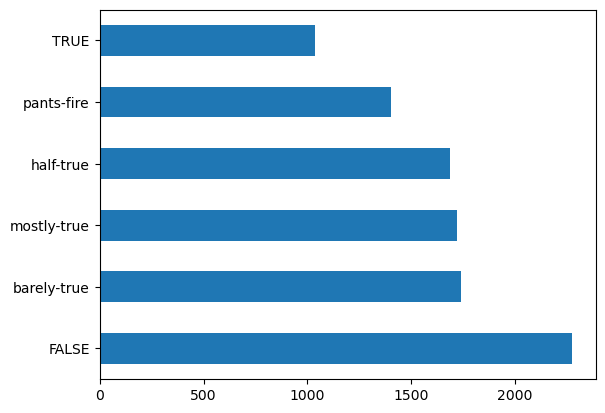

In [13]:
df['Label'].value_counts().plot(kind='barh')

In [14]:
for l in df.Label.unique():
    print('*************')
    print('LABEL :',l)
    for text in df[df['Label'] == l]['News_Headline'].sample(5).values:
        print(text,'\n')

*************
LABEL : FALSE
Say Bernie Sanders said, Italians are gangsters and Irish are drunk and Jews are greedy and black people smell. 

Says she "never received nor sent any material that was marked classified" on her private email server while secretary of state. 

Says a "liberal" immigration reform group endorsed his GOP primary opponent, Dave Brat. 

Says John F. Kennedy Jr. said, "If my dear friend Donald Trump ever decided to sacrifice his fabulous billionaire lifestyle to become president he would be an unstoppable force for ultimate justice that Democrats and Republicans alike would celebrate." 

"Here in Philadelphia murder has been steady  I mean  just terribly increasing." 

*************
LABEL : pants-fire
Says a photo shows Patrick Mahomes wearing a shirt that says, The Great State of Kansas. 

Says a photo shows Hillary Clinton shaking hands with Osama bin Laden. 

Says Barack Obama said that "ordinary men and women are too small-minded to govern their own aff

#### Manual observation

FALSE - believable misinformation <br>
pants-fire - bizarre and obvious misinformation <br>
barely-true - debatable information that is partially wrong<br>
TRUE - completely true information<br>
mostly-true - True events but with inaccurate quantitative values <br>
half-true - debatable information that is true <br>

Based on above results we combine the labels to make this a binary classification problem

True(1) - 'TRUE', 'mostly-true', 'half-true' <br>
False(0) - 'pants-fire','FALSE'

<AxesSubplot:>

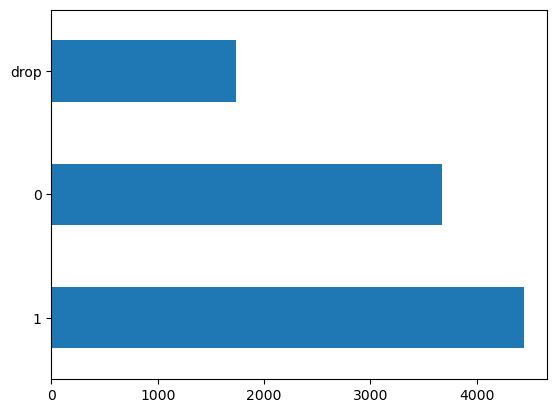

In [15]:
new_labels = []
for i,row in df.iterrows():
    true_labels = ['TRUE', 'mostly-true', 'half-true']
    false_labels = ['pants-fire','FALSE']
    
    if row['Label'] in true_labels:
        new_labels.append('1')
    elif row['Label'] in false_labels:
        new_labels.append('0')
    else:
        new_labels.append('drop')
        
df['new_labels'] = new_labels

df['new_labels'].value_counts().plot(kind='barh')

True (1) - 'TRUE' <br>
False (0) - 'FALSE'

<AxesSubplot:>

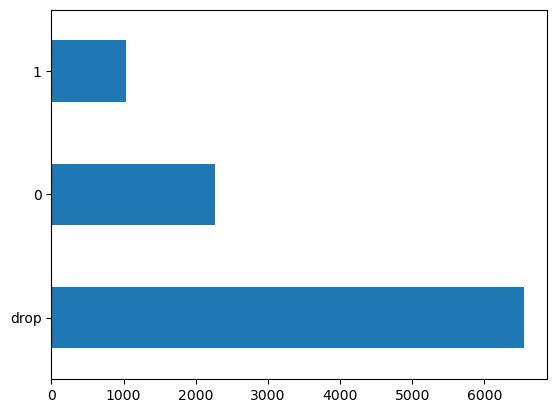

In [16]:
new_labels = []
for i,row in df.iterrows():
    true_labels = ['TRUE']
    false_labels = ['FALSE']
    
    if row['Label'] in true_labels:
        new_labels.append('1')
    elif row['Label'] in false_labels:
        new_labels.append('0')
    else:
        new_labels.append('drop')
        
df['new_labels_1'] = new_labels

df['new_labels_1'].value_counts().plot(kind='barh')

### Generating word clouds to understand new classes

Source: https://pypi.org/project/wordcloud/

In [17]:
from wordcloud import WordCloud

In [18]:
other_words = ['say','says']
stop_words = set(stopwords.words('english')+other_words)

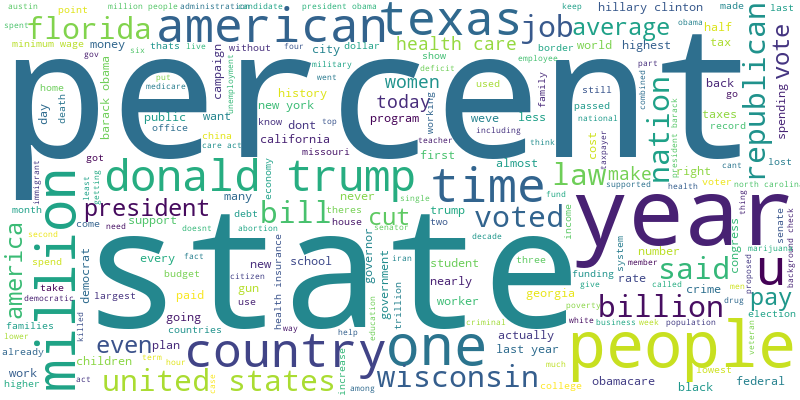

In [34]:
cls = '1'
corpus = ' '.join(df[df['new_labels'] == cls]['cleanText'])
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',scale=2)
corpus = ' '.join([word for word in corpus.split(' ') if word not in stop_words])
# Generate a word cloud
wordcloud.generate(corpus)
# Visualize the word cloud
wordcloud.to_image()

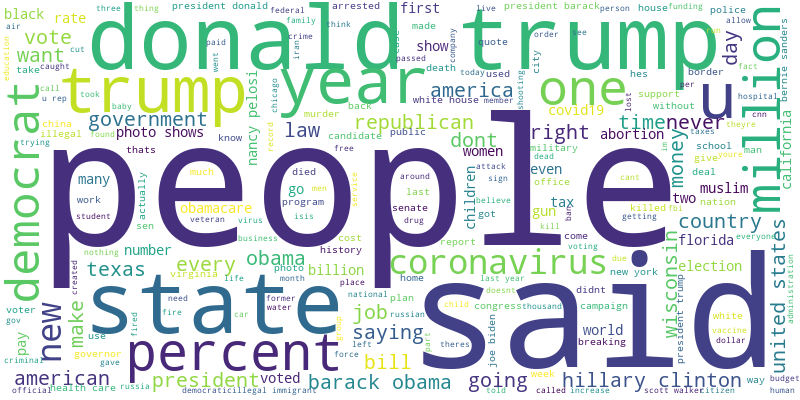

In [35]:
cls = '0'
corpus = ' '.join(df[df['new_labels'] == cls]['cleanText'])
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',scale=2)
corpus = ' '.join([word for word in corpus.split(' ') if word not in stop_words])
# Generate a word cloud
wordcloud.generate(corpus)
# Visualize the word cloud
wordcloud.to_image()

### Observations from word cloud

It is essential that both the word clouds have similar results. This will ensure that the model does not focus on using occurrences of certain words to classify news.

# Data Preparation

## Dataset Version 1

Renaming 'TRUE', 'mostly-true', 'half-true' as '1' (true information) <br>
Renaming 'pants-fire' and 'FALSE' as '0' (misinformation)<br>
Dropping remaining records

In [21]:
# Creating new dataframe with required fields
new_df = df[['cleanText', 'Link_Of_News', 'Source', 'Stated_On', 'Date', 'new_labels']]

In [22]:
# Dropping rows that are not required
new_df = new_df[new_df['new_labels'] != 'drop']

In [23]:
new_df.to_csv('kaggle_clean.csv',index=False)

# df = new_df.copy()

## Dataset Version 2

Renaming 'TRUE' as '1' (true information) <br>
Renaming 'FALSE' as '0' (misinformation)<br>
Dropping remaining records

In [24]:
# Creating new dataframe with required fields
df2 = df[['cleanText', 'Link_Of_News', 'Source', 'Stated_On', 'Date', 'new_labels_1']]

In [25]:
# Dropping rows that are not required
df2 = df2[df2['new_labels_1'] != 'drop']

In [26]:
df2.to_csv('kaggle_clean_only_true_false.csv',index=False)

# df = new_df.copy()

## Dataset Version 3

Modifying dataset Version 2 to balance number of labels

In [27]:
df_true = df2[df2['new_labels_1'] == '1'].copy()
df_false = df2[df2['new_labels_1'] == '0'].copy()

num_true = len(df_true)
df_false = df_false.sample(num_true,random_state=42)

df_balanced = pd.concat([df_true,df_false])
df_balanced[['cleanText','new_labels_1']].to_csv('kaggle_clean_only_true_false_balanced.csv',index=False)

df_balanced.shape

(2072, 6)

## ISOT Dataset preparation

In [28]:

# Preparing additional datasets for comparison

df1 = pd.read_csv('ISOT/Fake.csv',encoding = 'latin-1')
df2 = pd.read_csv('ISOT/True.csv',encoding = 'latin-1')

df1['label'] = 0
df2['label'] = 1

df_isot = pd.concat([df1,df2])

df_isot['cleanText'] = df_isot['text'].apply(preprocess)

df_isot[['cleanText','label']].to_csv('ISOT_clean.csv',index=False)


## FA-KES Dataset Preparation

In [29]:
df_fakes = pd.read_csv('FA-KES-Dataset.csv',encoding = 'latin-1')

df_fakes['cleanText'] = df_fakes['article_content'].apply(preprocess)

df_fakes[['cleanText','labels']].to_csv('fakes_clean.csv',index=False)